# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from numpy.random import seed
medical = pd.read_csv('insurance2.csv')

In [13]:
medical.shape

(1338, 8)

In [14]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__ the data has a right tail, but we have to keep in mind that this is just a single sample from a larger population

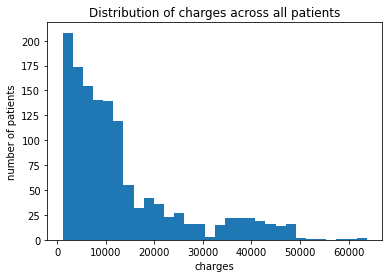

In [15]:
_ = plt.hist(medical['charges'], bins=30)
_ = plt.xlabel('charges')
_ = plt.ylabel('number of patients')
_ = plt.title('Distribution of charges across all patients')
plt.show()

In [16]:
charges_mean = np.mean(medical['charges'])
charges_std = np.std(medical['charges'])
print(charges_mean)
print(charges_std)

13270.422265141257
12105.484975561605


__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__ - bootstrap sampling, and hypothesis testing, null hypothesis = the average charge per patient is < 12,000

In [19]:
#perform bootstrap sampling of charges
charges = np.array(medical['charges'])
def bootstrap_replicate_1d(data, func):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

bs_replicates = draw_bs_reps(charges, np.mean, size=10000)

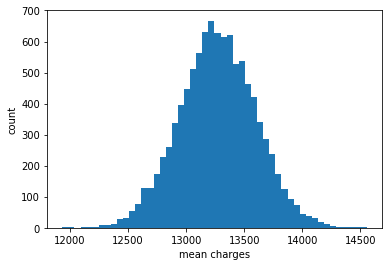

In [21]:
#plot mean charges
_ = plt.hist(bs_replicates, bins=50)
_ = plt.xlabel('mean charges')
_ = plt.ylabel('count')
plt.show()

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

__A:__ I should use a left-tailed test (one-sided interval)

In [22]:
# calculate t-statistic and critical value (t-statistic)
df = len(charges) - 1
t_value = t.ppf([0.05], df=df)
print("t-statistic: ", t_value)
stan_error = np.std(charges)/np.sqrt(len(charges))
critical_value = t_value * stan_error
print("critical value: ", critical_value)

t-statistic: [-1.64599411]
critical value: [-544.73140534]


In [24]:
#calculate 95% CI (left-sided)
conf_int = np.percentile(bs_replicates, [5])
print("95% confidence interval: ", conf_int)

95% confidence interval:  [12723.31302455]


In [25]:
#null hypothesis significance testing
p_value = np.sum(bs_replicates < 12000) / 10000
print("p-value: ", p_value)

p-value:  0.0001


With a p-value of 0.0001, it is very unlikely that the true mean is less than 12000, and therefore we must reject the null hypothesis. 

The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

__A:__ Null hypothesis = People with insurance are charged the same amount as people without. 
Alternative hypothesis = People with insurance are charged a different amount than people without. 



__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

In [30]:
charges_insured = medical.loc[medical['insuranceclaim']==1, ['charges']]
print(charges_insured.head())
charges_uninsured = medical.loc[medical['insuranceclaim']==0, ['charges']]
print(charges_uninsured.head())

       charges
0   16884.9240
1    1725.5523
4    3866.8552
6    8240.5896
10   2721.3208
       charges
2   4449.46200
3  21984.47061
5   3756.62160
7   7281.50560
8   6406.41070


In [33]:
n1 = len(charges_insured)
s1 = np.std(charges_insured, ddof=1)
x1 = np.mean(charges_insured)
print("insured size: ", n1, ", insured std: ", s1, ", insured mean: ", x1)
n2 = len(charges_uninsured)
s2 = np.std(charges_uninsured, ddof=1)
x2 = np.mean(charges_uninsured)
print("uninsured size: ", n2, ", uninsured std: ", s2, ", uninsured mean: ", x2)
s_pool = np.sqrt((((n1-1)*(s1**2))+((n2-1)*(s2**2)))/(n1+n2-2))
print(s_pool)

insured size:  783 , insured std:  charges    14045.928419
dtype: float64 , insured mean:  charges    16423.928277
dtype: float64
uninsured size:  555 , uninsured std:  charges    6446.510127
dtype: float64 , uninsured mean:  charges    8821.421892
dtype: float64
charges    11520.034269
dtype: float64


In [35]:
t_stat = (x1-x2)/(s_pool*np.sqrt((1/n1)+(1/n2)))
print("t-statistic: ", t_stat)

t-statistic:  charges    11.893299
dtype: float64


In [36]:
df = n1 + n2 - 2
print(df)
#p-value is 0

1336


In [39]:
from scipy import stats
print(stats.ttest_ind(charges_insured, charges_uninsured))

Ttest_indResult(statistic=array([11.89329903]), pvalue=array([4.46123023e-31]))


Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__ I don't see a z-test equivalent, perhaps because its rare to have data for the full population. 

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test